In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

In [2]:
ori = pd.read_csv("../tests/datasets/student_train.csv")
syn = pd.read_csv("../tests/datasets/student_syn_ctgan.csv")
control = pd.read_csv("../tests/datasets/student_control.csv")

In [3]:
ori.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
for i in range (10, 30, 5):

    evaluator = SinglingOutEvaluator(ori=ori, 
                                    syn=syn, 
                                    control=control,
                                    n_attacks=i)

    evaluator.evaluate(mode='univariate')
    risk = evaluator.risk()
    print("n_attacks =", i, '|', risk)

C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.1387663999314446, baseline = 0.21101311994515567. Analysis results cannot be trusted.
  self._sanity_check()


n_attacks = 10 | PrivacyRisk(value=0.0, ci=(0.0, 0.22786538375780568))


Found 1 failed queries out of 20. Check DEBUG messages for more details.


n_attacks = 15 | PrivacyRisk(value=0.07118294555681086, ci=(0.0, 0.32178740112925336))


Found 2 failed queries out of 25. Check DEBUG messages for more details.


n_attacks = 20 | PrivacyRisk(value=0.006812454756356122, ci=(0.0, 0.1849769550560998))


Attack `univariate` could generate only 24 singling out queries out of the requested 25. This can probably lead to an underestimate of the singling out risk.


n_attacks = 25 | PrivacyRisk(value=0.011385326428894605, ci=(0.0, 0.1903594671855289))


In [5]:
evaluator = SinglingOutEvaluator(ori=ori, 
                                syn=syn, 
                                control=control,
                                n_attacks=15)

evaluator.evaluate(mode='univariate')
risk = evaluator.risk()
print("n_attacks =", i, '|', risk)

n_attacks = 25 | PrivacyRisk(value=0.07118294555681086, ci=(0.0, 0.32178740112925336))


In [6]:
evaluator.queries()[:3]

['G3 == 19', 'absences == 26']

In [7]:
evaluator.risk(confidence_level=0.95)

PrivacyRisk(value=0.07118294555681086, ci=(0.0, 0.32178740112925336))

In [8]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.20809054371314448, error=0.17072928461007914)
Successs rate of baseline attack: SuccessRate(value=0.1019416505179243, error=0.10194165051792431)
Successs rate of control attack: SuccessRate(value=0.1473999615978278, error=0.13831513438587623)


Note that you can obtain the `PrivacyRisk` from the attack results by:

In [9]:
res.risk()

PrivacyRisk(value=0.07118294555681086, ci=(0.0, 0.32178740112925336))

In [27]:
for i in range (5, 15, 1):
    evaluator = SinglingOutEvaluator(ori=ori, 
                                    syn=syn, 
                                    control=control,
                                    n_attacks=13, # this attack takes longer
                                    n_cols=4)

    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print("n_attacks =", i, '|', risk)

Found 3 failed queries out of 13. Check DEBUG messages for more details.
Found 2 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 5 | PrivacyRisk(value=0.0813054980289304, ci=(0.0, 0.3648051686405654))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.11404768617709919, baseline = 0.17342496522677625. Analysis results cannot be trusted.
  self._sanity_check()
Found 4 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 6 | PrivacyRisk(value=0.0, ci=(0.0, 0.18205018716296864))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.11404768617709919, baseline = 0.11404768617709919. Analysis results cannot be trusted.
  self._sanity_check()
Found 2 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 7 | PrivacyRisk(value=0.0, ci=(0.0, 0.18205018716296864))
n_attacks = 8 | PrivacyRisk(value=0.06702085216467575, ci=(0.0, 0.2836385212512319))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.11404768617709919, baseline = 0.11404768617709919. Analysis results cannot be trusted.
  self._sanity_check()
Found 2 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 9 | PrivacyRisk(value=0.0, ci=(0.0, 0.18205018716296864))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.11404768617709919, baseline = 0.11404768617709919. Analysis results cannot be trusted.
  self._sanity_check()
Found 3 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 10 | PrivacyRisk(value=0.0, ci=(0.0, 0.17812109590793448))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.11404768617709919, baseline = 0.2328022442764533. Analysis results cannot be trusted.
  self._sanity_check()
Found 1 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 11 | PrivacyRisk(value=0.0, ci=(0.0, 0.17812109590793448))


Found 1 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 12 | PrivacyRisk(value=0.06702085216467575, ci=(0.0, 0.2836385212512319))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.11404768617709919, baseline = 0.2328022442764533. Analysis results cannot be trusted.
  self._sanity_check()
Found 1 failed queries out of 13. Check DEBUG messages for more details.


n_attacks = 13 | PrivacyRisk(value=0.0, ci=(0.0, 0.17019685212963356))
n_attacks = 14 | PrivacyRisk(value=0.0813054980289304, ci=(0.0, 0.3648051686405654))


In [28]:
evaluator.queries()[:3]

["romantic== 'yes' & sex== 'F' & Fjob== 'at_home' & famsup== 'no'",
 "goout<= 2 & nursery== 'yes' & reason== 'other' & school== 'MS'"]

In [35]:
aux_cols = [
    ['Mjob', 'Fjob', 'G1', 'G2', 'G3'],
    [ 'sex', 'age', 'famsize', 'guardian', 'school']
]

evaluator = LinkabilityEvaluator(ori=ori, 
                                syn=syn, 
                                control=control,
                                n_attacks=70,
                                aux_cols=aux_cols,
                                n_neighbors=10)

evaluator.evaluate(n_jobs=-2)  # n_jobs follow joblib convention. -1 = all cores, -2 = all execept one
print(evaluator.risk())

PrivacyRisk(value=0.016971955541072965, ci=(0.0, 0.17760105797738132))


C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.21560691872308008, baseline = 0.22914944640293342. Analysis results cannot be trusted.
  self._sanity_check()


In [36]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.21560691872308008, error=0.09255952623945055)
Successs rate of baseline attack: SuccessRate(value=0.22914944640293342, error=0.0947624162318555)
Successs rate of control attack: SuccessRate(value=0.20206439104322674, error=0.09019139102420641)


In [14]:
print(evaluator.risk(n_neighbors=6))

PrivacyRisk(value=0.052686532796335984, ci=(0.0, 0.15449685054412307))


In [37]:
columns = ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=ori, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=100)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))

C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.6540810402868823, baseline = 0.6829712353406727. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.42295947985655885, baseline = 0.432589544874489. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.2110980494620957, baseline = 0.2110980494620957. Analysis results cannot be trusted.
  self._sanity_check()
C:\Users\kshit\Desktop\anonymeter\src\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.6155607802151617, baseline = 0.6

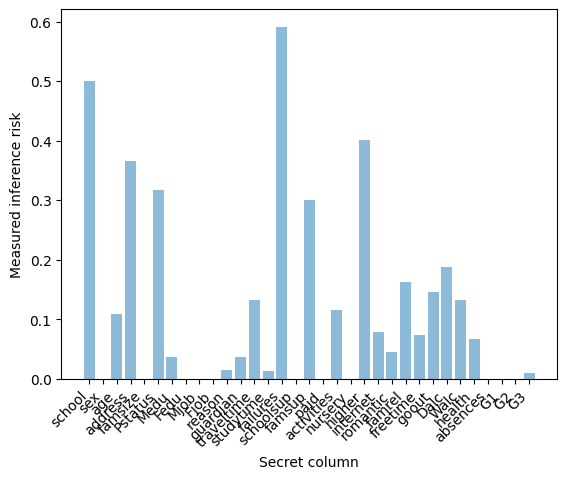

In [38]:
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

As visible, many columns in the dataset carry a significant inference risk. This means that an attacker in possession of the synthetic dataset can use it to infer some attribute of records in the original data.